<h3>Importing Libraries</h3>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

<h3>Reading input data</h3>

In [4]:
df_clinnotes = pd.read_csv("ClinNotes.csv")

In [5]:
df_clinnotes.head(3)

,category,notes
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."


In [6]:
df_medicalconcept = pd.read_csv("MedicalConcepts.csv")

In [7]:
df_medicalconcept.head()

,Term1,Term2
0,Glaucoma,Fibrillation
1,Carbatrol,Dilantin
2,Cardiomyopathy,Tylenol
3,Herpes,Hyperthyroidism
4,Seasickness,Nausea


In [8]:
df_clinnotes.shape

(818, 2)

In [9]:
df_clinnotes['category'].value_counts(normalize=True).mul(100).round(1).astype('str') + '%'

Cardiovascular / Pulmonary    45.4%
Gastroenterology              27.4%
Neurology                     27.3%
Name: category, dtype: object

In [10]:
df_clinnotes.groupby(['category']).sample(n=2)

,category,notes
461,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSES:,1. Hyperpyrexia/leuko..."
467,Cardiovascular / Pulmonary,"REASON FOR EXAM: , Vegetation and bacteremia.,..."
439,Gastroenterology,"PREOPERATIVE DIAGNOSIS: , Hematemesis in a pa..."
412,Gastroenterology,"PREOPERATIVE DIAGNOSES:, Prior history of ane..."
56,Neurology,"HISTORY: , Neurologic consultation was request..."
120,Neurology,She also had EMG/nerve conduction studies sinc...


<h3>Exploratory Data Analysis</h3>

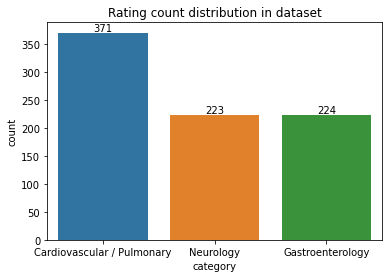

In [11]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x=df_clinnotes['category'], ax=ax)
for rect in ax.patches:
    ax.annotate(rect.get_height(), (rect.get_x() + rect.get_width()/2, rect.get_height()), ha='center', xytext=(0,2), textcoords='offset points')
ax.set_title("Rating count distribution in dataset")
plt.show()

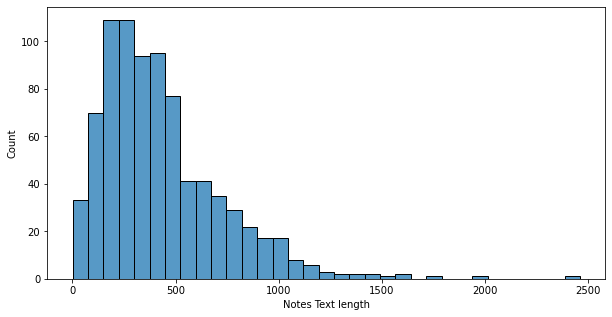

In [12]:
fig, ax1 = plt.subplots(figsize=(10,5))
sns.histplot(x=df_clinnotes['notes'].str.split().str.len(), ax=ax1)
#ax1.set(xlim=(0, 10000))
ax1.set_xlabel("Notes Text length")
plt.show()

<h3>Clean text</h3>

In [13]:
stop_words = stopwords.words('english')

In [14]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [15]:
#removing stop words
df_clinnotes['clean_notes'] = df_clinnotes['notes'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stop_words)]))


In [16]:
#removing puntuation
df_clinnotes["clean_notes"] = df_clinnotes['clean_notes'].str.replace('[^\w\s]','', regex=True)

In [17]:
#lemetizing the text
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

In [18]:
df_clinnotes['clean_notes'] = df_clinnotes['clean_notes'].apply(lemmatize_text)

In [19]:
df_clinnotes.head()

,category,notes,clean_notes
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2D MMODE 1 Left atrial enlargement left atrial...
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,1 left ventricular cavity size wall thickness ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...",2D ECHOCARDIOGRAMMultiple view heart great ves...
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....",DESCRIPTION1 Normal cardiac chamber size2 Norm...
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...",2D STUDY1 Mild aortic stenosis widely calcifie...


In [20]:
def get_topngrams(corpus, n):
    vec = CountVectorizer(analyzer='word', lowercase=True, ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    freqs = zip(vec.get_feature_names(), sum_words.tolist()[0])    
    # sort from largest to smallest
    sorted_list = sorted(freqs, key=lambda x: x[1], reverse=True)
    return sorted_list[:100]

In [21]:
#notes_word_count = df_clinnotes['notes'].str.split().explode().value_counts().to_dict()

In [25]:
wordcloud = WordCloud(background_color='white', max_words=100, max_font_size=30, scale=3, random_state=42)

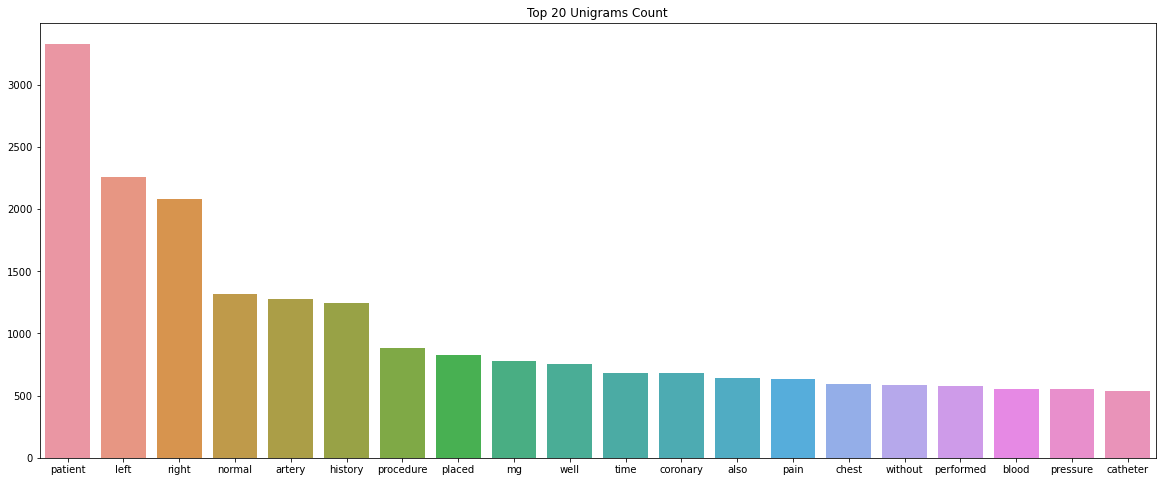

In [24]:
#Plot top unigrams
top_unigrams = get_topngrams(df_clinnotes['clean_notes'], 1)
x,y = map(list,zip(*top_unigrams[:20]))
plt.figure(figsize=(20,8))
sns.barplot(x=x, y=y)
plt.title('Top 20 Unigrams Count')
plt.show()

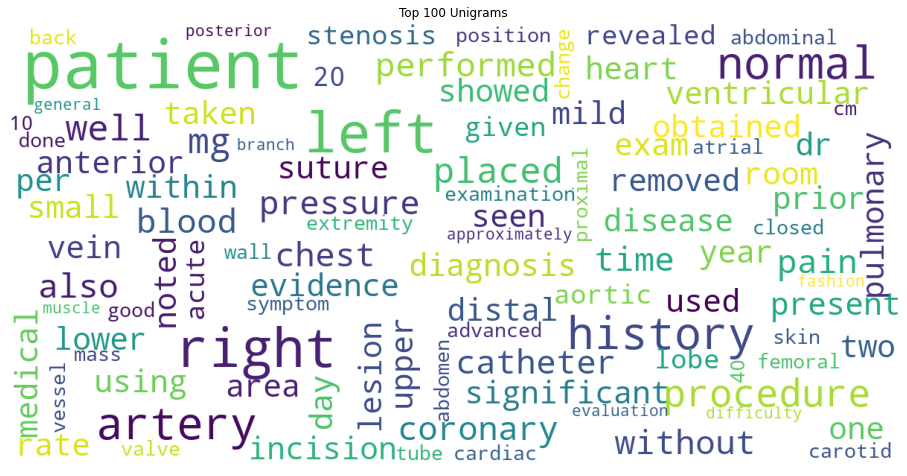

In [26]:
wc = wordcloud.generate_from_frequencies(dict(top_unigrams))
fig = plt.figure(1, figsize=(16, 12))
plt.axis('off')
plt.imshow(wc)
plt.title('Top 100 Unigrams')
plt.show()

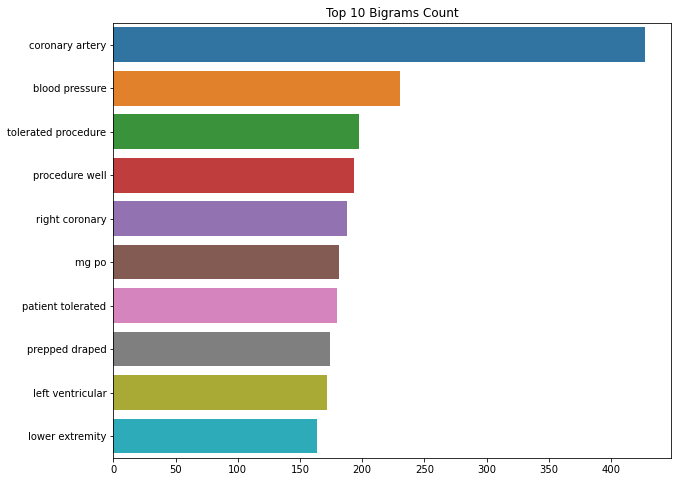

In [27]:
#Plot top bigrams
top_bigrams = get_topngrams(df_clinnotes['clean_notes'], 2)
x,y = map(list,zip(*top_bigrams[:10]))
plt.figure(figsize=(10,8))
sns.barplot(x=y, y=x)
plt.title('Top 10 Bigrams Count')
plt.show()

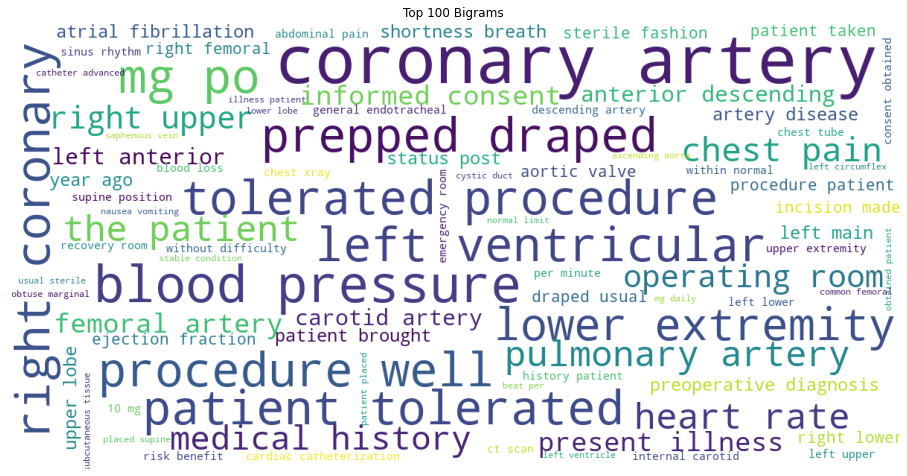

In [29]:
wc = wordcloud.generate_from_frequencies(dict(top_bigrams))
fig = plt.figure(1, figsize=(16, 12))
plt.axis('off')
plt.imshow(wc)
plt.title('Top 100 Bigrams')
plt.show()

Text(0.5, 1.0, 'Top 10 Trigrams Count')

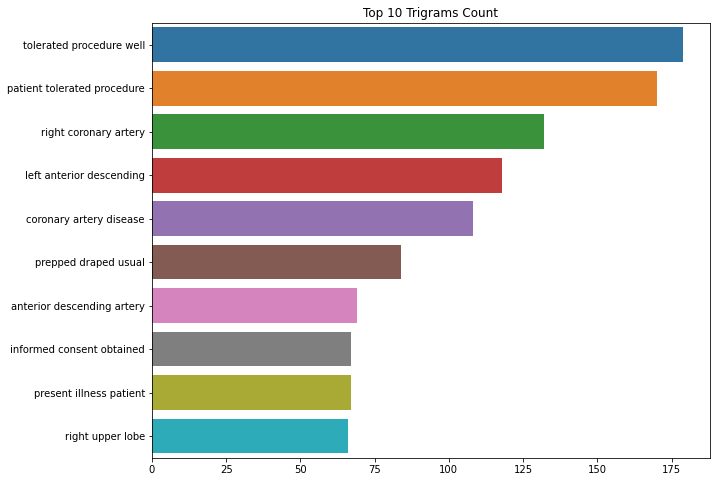

In [30]:
#Plot top trigrams
top_trigrams = get_topngrams(df_clinnotes['clean_notes'], 3)
x,y = map(list,zip(*top_trigrams[:10]))
plt.figure(figsize=(10,8))
sns.barplot(x=y, y=x)
plt.title('Top 10 Trigrams Count')

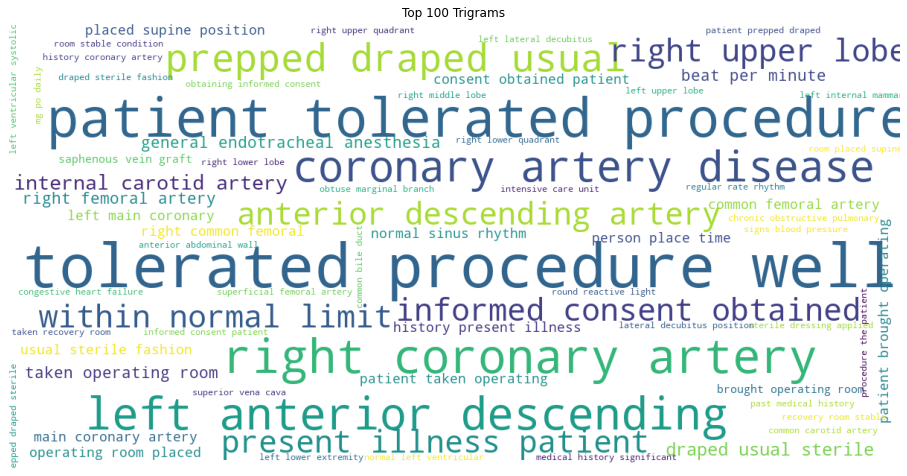

In [31]:
wc = wordcloud.generate_from_frequencies(dict(top_trigrams))
fig = plt.figure(1, figsize=(16, 12))
plt.axis('off')
plt.imshow(wc)
plt.title('Top 100 Trigrams')
plt.show()